In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import csv

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d arpitjain007/game-of-deep-learning-ship-datasets --force
!unzip game-of-deep-learning-ship-datasets.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/images/2829342.jpg  
  inflating: train/images/2829344.jpg  
  inflating: train/images/2829347.jpg  
  inflating: train/images/2829351.jpg  
  inflating: train/images/2829357.jpg  
  inflating: train/images/2829359.jpg  
  inflating: train/images/2829362.jpg  
  inflating: train/images/2829366.jpg  
  inflating: train/images/2829369.jpg  
  inflating: train/images/2829372.jpg  
  inflating: train/images/2829373.jpg  
  inflating: train/images/2829377.jpg  
  inflating: train/images/2829378.jpg  
  inflating: train/images/2829381.jpg  
  inflating: train/images/2829382.jpg  
  inflating: train/images/2829383.jpg  
  inflating: train/images/2829385.jpg  
  inflating: train/images/2829386.jpg  
  inflating: train/images/2829387.jpg  
  inflating: train/images/2829389.jpg  
  inflating: train/images/2829390.jpg  
  inflating: train/images/2829393.jpg  
  inflating: train/images/2829394.jpg  
  inflating: train/images/282

In [4]:
main_path = "./train/images/"
train_df = pd.read_csv("train/train.csv")
paths = os.listdir(main_path)
train_df['path'] = main_path + train_df['image']
categories = list(train_df['category'])
category = {1:'Cargo', 2:'Military', 3:'Carrier', 4:'Cruise', 5:'Tankers'}
classes = []
for c in categories:
    classes.append(category[c])
train_df['classes'] = classes
train_df.head()

image  category                        path   classes
0  2823080.jpg         1  ./train/images/2823080.jpg     Cargo
1  2870024.jpg         1  ./train/images/2870024.jpg     Cargo
2  2662125.jpg         2  ./train/images/2662125.jpg  Military
3  2900420.jpg         3  ./train/images/2900420.jpg   Carrier
4  2804883.jpg         2  ./train/images/2804883.jpg  Military

In [5]:
test_df = pd.read_csv('./test_ApKoW4T.csv')
test_df['path'] = main_path + test_df['image']

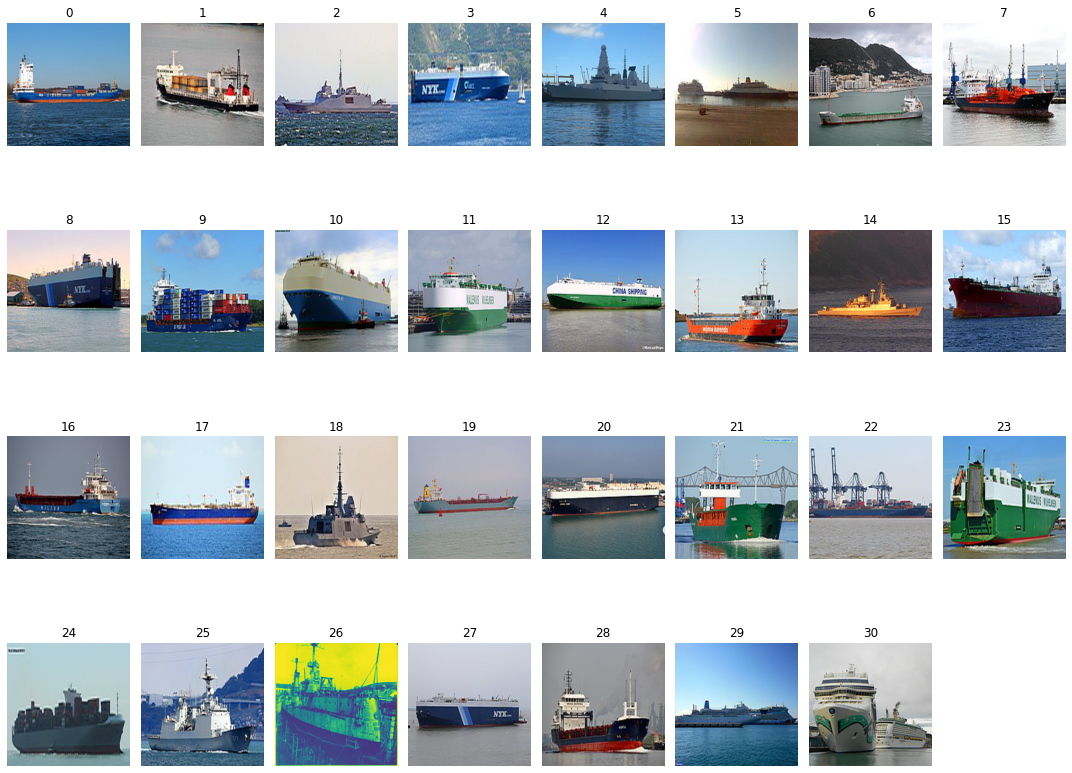

In [6]:
plt.figure(figsize = (15,12))
for id,image_path in enumerate(train_df['path']):
    if id==31:
        break
    plt.subplot(4,8,id+1)
    img = PIL.Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(id)
plt.tight_layout()
plt.show()

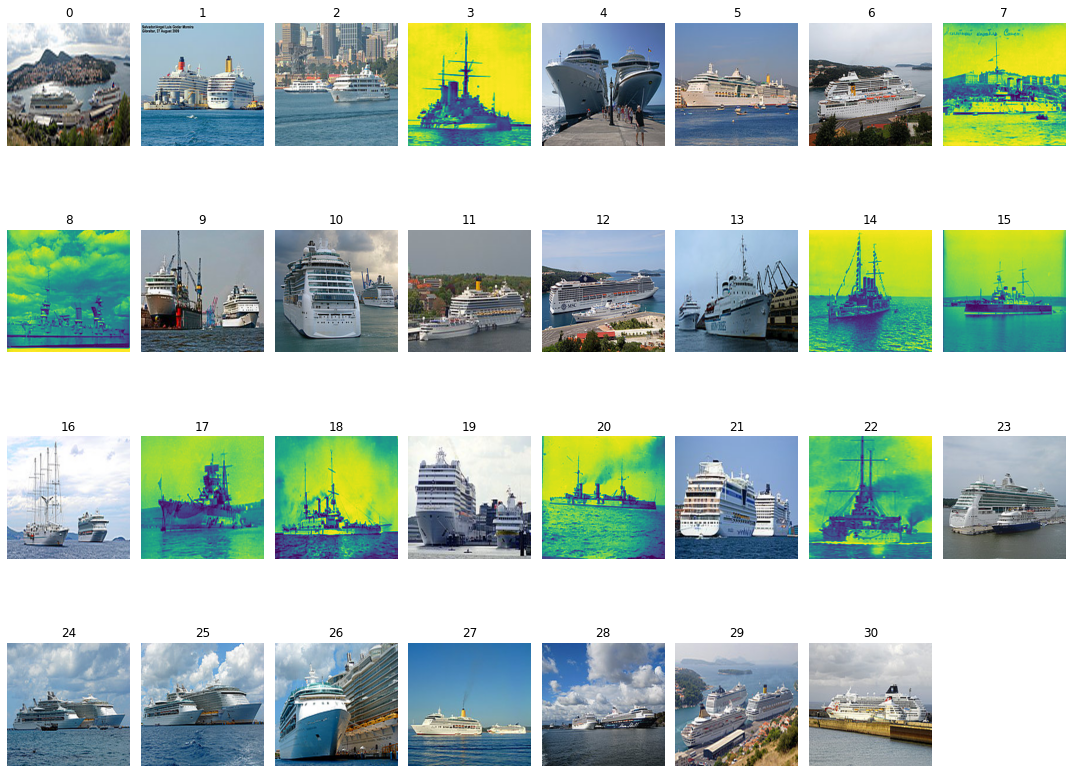

In [7]:
plt.figure(figsize = (15,12))
for id,image_path in enumerate(test_df['path']):
    if id==31:
        break
    plt.subplot(4,8,id+1)
    img = PIL.Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(id)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
X, y = train_df[['path', 'classes']], train_df['classes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras.applications.resnet50 import preprocess_input

resnet50_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(192, 192),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_test,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(192, 192),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 5001 validated image filenames belonging to 5 classes.
Found 1251 validated image filenames belonging to 5 classes.


In [9]:
def plot_augimages(paths, datagen):
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')
    
    midx = 0
    for path in paths:
        data = PIL.Image.open(path)
        data = data.resize((192,192))
        samples = np.expand_dims(data, 0)
        it = datagen.flow(samples, batch_size=1)
    
        # Show Original Image
        plt.subplot(10,5, midx+1)
        plt.imshow(data)
        plt.axis('off')
    
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)
            
            batch = it.next()
            image = batch[0].astype('uint8')
            plt.imshow(image)
            plt.axis('off')
        midx += 1
    
    plt.tight_layout()
    plt.show()

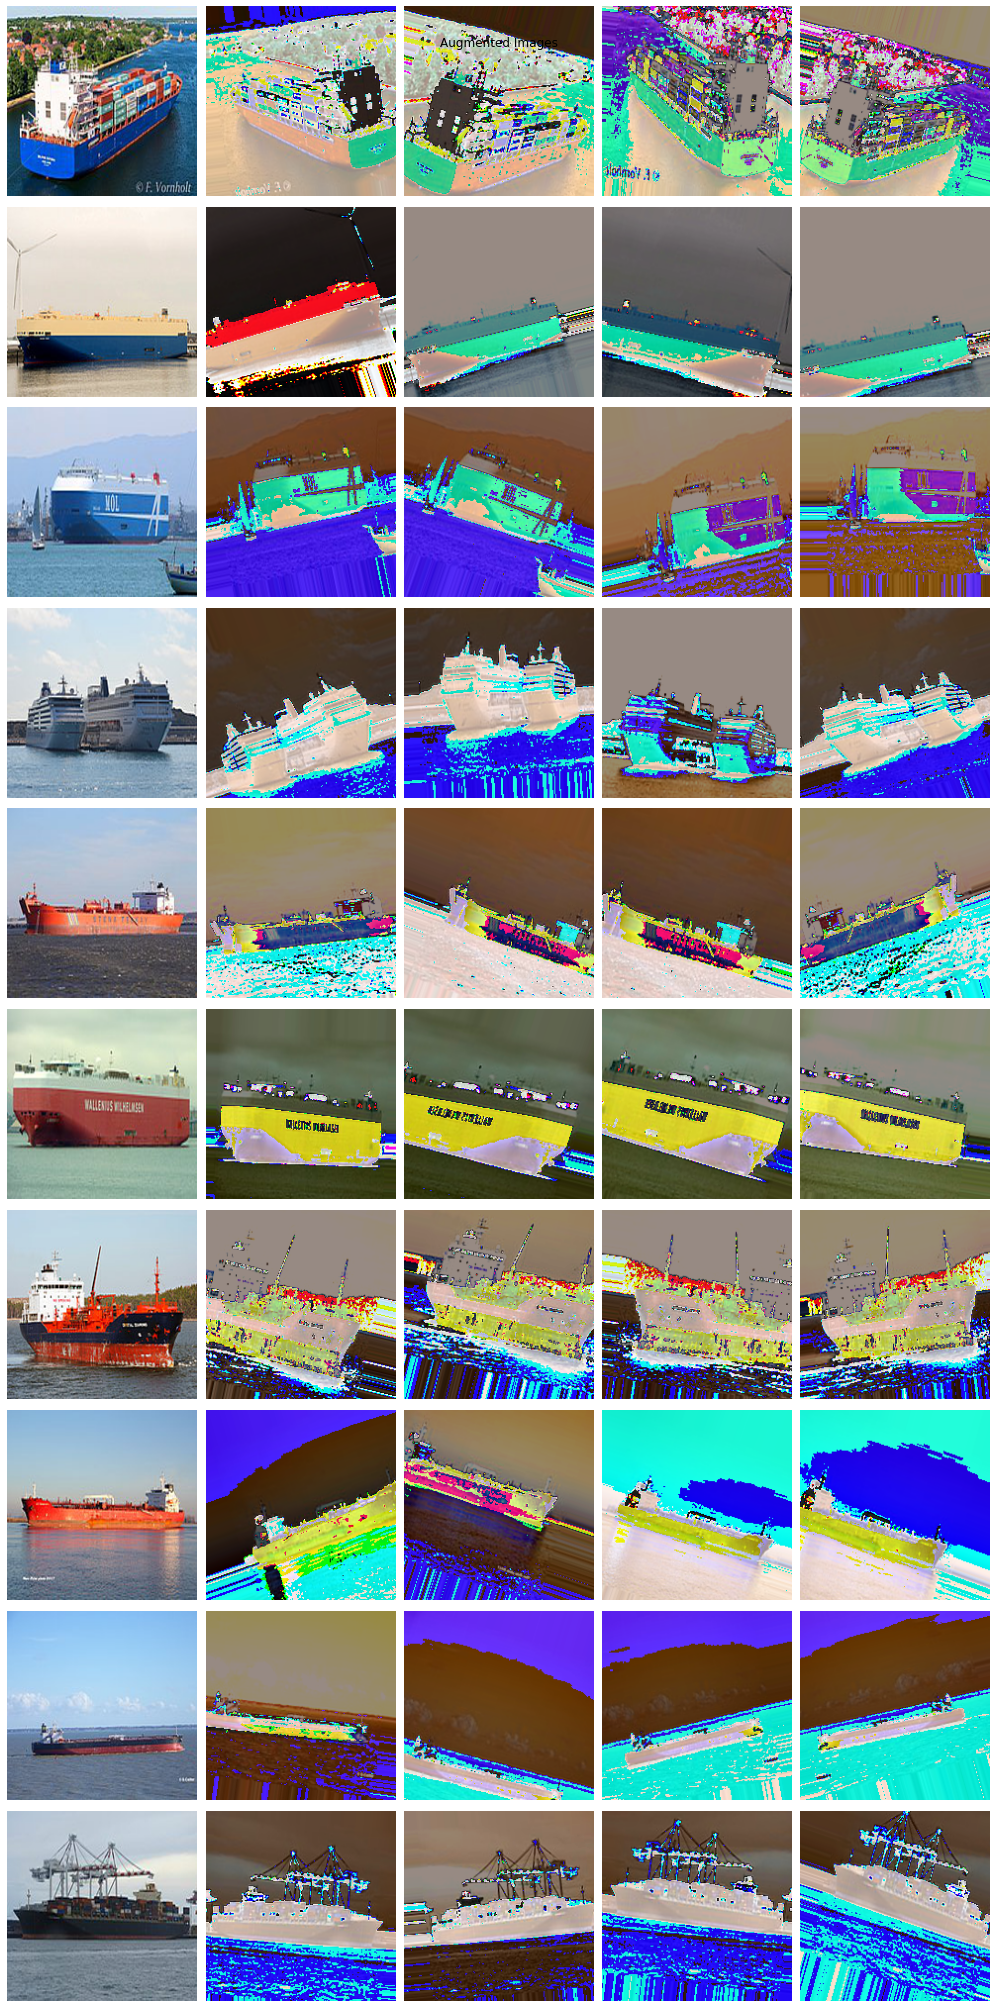

In [10]:
try:
  plot_augimages(np.random.choice(train_df['path'],10), resnet50_datagen)
except:
  print("Continue no issues")

In [17]:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top = False, input_shape = (192,192,3), weights = 'imagenet')
optimizer=Adam(learning_rate=0.001)

# training of all the convolution is set to false
for layer in resnet50.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet50.output)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

model_resnet50 = tf.keras.Model(inputs = resnet50.input, outputs = predictions)

In [18]:
from sklearn.metrics import cohen_kappa_score
def kappa_metric(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    return tf.py_function(cohen_kappa_score, (y_true, y_pred), tf.double)

model_resnet50.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[kappa_metric])

In [19]:
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=50,
      verbose=2)

Epoch 1/50
157/157 - 119s - loss: 0.6958 - kappa_metric: 0.6438 - val_loss: 0.4998 - val_kappa_metric: 0.7346 - 119s/epoch - 757ms/step
Epoch 2/50
157/157 - 67s - loss: 0.4525 - kappa_metric: 0.7664 - val_loss: 0.4511 - val_kappa_metric: 0.7789 - 67s/epoch - 425ms/step
Epoch 3/50
157/157 - 67s - loss: 0.4084 - kappa_metric: 0.7873 - val_loss: 0.4504 - val_kappa_metric: 0.7632 - 67s/epoch - 426ms/step
Epoch 4/50
157/157 - 67s - loss: 0.3788 - kappa_metric: 0.7950 - val_loss: 0.4270 - val_kappa_metric: 0.7952 - 67s/epoch - 425ms/step
Epoch 5/50
157/157 - 66s - loss: 0.3614 - kappa_metric: 0.8175 - val_loss: 0.4458 - val_kappa_metric: 0.7801 - 66s/epoch - 421ms/step
Epoch 6/50
157/157 - 67s - loss: 0.3428 - kappa_metric: 0.8284 - val_loss: 0.4091 - val_kappa_metric: 0.7946 - 67s/epoch - 426ms/step
Epoch 7/50
157/157 - 67s - loss: 0.3452 - kappa_metric: 0.8178 - val_loss: 0.3886 - val_kappa_metric: 0.7827 - 67s/epoch - 427ms/step
Epoch 8/50
157/157 - 66s - loss: 0.3282 - kappa_metric: 0.82

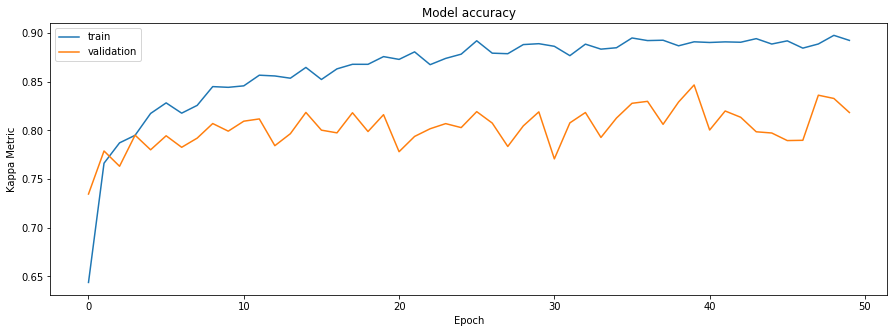

In [20]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['kappa_metric'])
plt.plot(history_resnet50.history['val_kappa_metric'])
plt.title('Model accuracy')
plt.ylabel('Kappa Metric')
plt.xlabel('Epoch')
plt.legend(["train","validation"])
plt.show()

In [28]:
import cv2
img = cv2.imread(test_df['path'][0])
img = cv2.resize(img,(192,192))
img = np.expand_dims(img,axis=0)


In [29]:
image_pred = model_resnet50.predict(img)
print(image_pred)
image_output_class=category[np.argmin(image_pred)]

print("The predicted class is", image_output_class)

1/1 [==============================] - 0s 21ms/step
[[1.2307386e-07 2.5979119e-10 9.9652267e-01 3.4754451e-03 1.7978954e-06]]
The predicted class is Cargo
